In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

In [3]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

In [4]:
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

In [5]:
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

In [6]:
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 4 else 1)
test_df['label'] = -1 # Placeholder label for the test data

In [7]:
def preprocess_text(input_text):
    # Convert to lowercase
    input_text = input_text.lower()
    # Exclude punctuation, special characters and digits
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    # Trim extra spaces and newlines
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    # Exclude stop words
    stopword_list = TfidfVectorizer(stop_words='english').get_stop_words()
    word_list = input_text.split()
    word_list = [word for word in word_list if word not in stopword_list]
    input_text = ' '.join(word_list)
    return input_text

# Define the transformer for text and variables column with SelectKBest
transformer_text_vars = ColumnTransformer([
    ('review', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), preprocessor=preprocess_text)), 
                       ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'reviewText'),
    ('summary_text', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), preprocessor=preprocess_text)), 
                          ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'summary'),
    ('verified_status', OneHotEncoder(), ['verified']),
    ('vote_count', 'passthrough', ['vote']) 
])

# Split the training dataset into train and validation sets
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

# Combine the text data with other relevant variables
train_features_transformed = transformer_text_vars.fit_transform(train_set[['reviewText', 'summary', 'verified', 'vote']], train_set['label'])
valid_features_transformed = transformer_text_vars.transform(valid_set[['reviewText', 'summary', 'verified', 'vote']])
test_features_transformed = transformer_text_vars.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label_transformed = train_set['label']
valid_label_transformed = valid_set['label']

# Apply SelectKBest to the combined features
best_k_selection_final = SelectKBest(f_classif, k='all')
train_features_kbest_final = best_k_selection_final.fit_transform(train_features_transformed, train_label_transformed)
valid_features_kbest_final = best_k_selection_final.transform(valid_features_transformed)
test_features_kbest_final = best_k_selection_final.transform(test_features_transformed)

# Combine the text data with other relevant variables
train_features_final = np.hstack((train_features_kbest_final.toarray(), train_features_transformed[:, [2, 3, 4]].toarray()))
valid_features_final = np.hstack((valid_features_kbest_final.toarray(), valid_features_transformed[:, [2, 3, 4]].toarray()))
test_features_final = np.hstack((test_features_kbest_final.toarray(), test_features_transformed[:, [2, 3, 4]].toarray()))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1 Score: 0.700927419013912 +/- 0.005982940982570804 for {'C': 1}
Mean F1 Score: 0.7482493013403415 +/- 0.006806903180611027 for {'C': 10}
Mean F1 Score: 0.7539684553329365 +/- 0.007663065535998124 for {'C': 50}
Mean F1 Score: 0.7542147147631015 +/- 0.007848778667437169 for {'C': 100}
Mean F1 Score: 0.7560158711456001 +/- 0.008445807846864868 for {'C': 150}
Logistic Regression Classifier with rating cutoff of 4
Best Parameters: {'C': 150}
Best F1 Score: 0.7560158711456001
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.94      0.91      4705
           1       0.63      0.45      0.53      1133

    accuracy                           0.84      5838
   macro avg       0.75      0.69      0.72      5838
weighted avg       0.83      0.84      0.83      5838

Confusion Matrix:
 [[4404  301]
 [ 620  513]]
Accuracy: 0.84224049331963
AUC Score: 0.8612148537780225



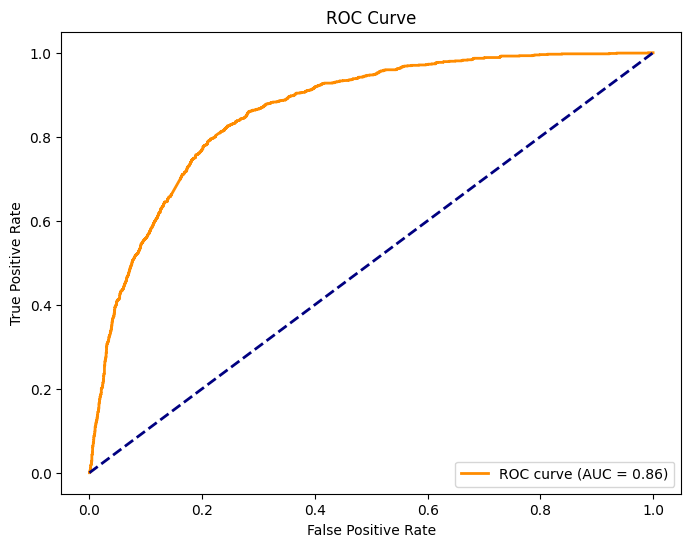

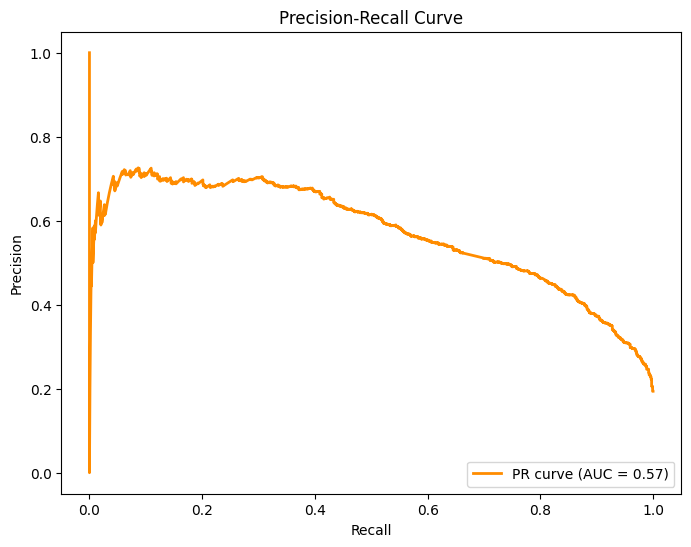

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the logistic regression classifier and its hyperparameters
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_params = {'C': [1, 10, 50, 100, 150]}

# Train and evaluate the logistic regression classifier using 5-fold cross-validation
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1_macro')
lr_grid.fit(train_features_final, train_label_transformed)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = lr_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Logistic Regression Classifier with rating cutoff of 4')
print('Best Parameters:', lr_grid.best_params_)
print('Best F1 Score:', lr_grid.best_score_)

# Compute the validation metrics for the best model
best_lr = lr_grid.best_estimator_
valid_pred = best_lr.predict(valid_features_final)
print('Classification Report:', classification_report(valid_label_transformed, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_pred))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_pred))
print('AUC Score:', roc_auc_score(valid_label_transformed, best_lr.predict_proba(valid_features_final)[:,1]))
print('')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label_transformed, best_lr.predict_proba(valid_features_final)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, best_lr.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use the best classifier to make predictions on the test data
test_pred = best_lr.predict(test_features_final)
test_df['predicted'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['binary_split_4']})
submission_df.to_csv('Logistic_Regression_4_withoutSK_submission.csv', index=False)



In [16]:
# Use the best classifier to make predictions on the test data
test_pred = best_lr.predict(test_features_final)
test_df['predicted'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['predicted']})
submission_df.to_csv('Logistic_Regression_4_withoutSK_submission.csv', index=False)


Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 1}
Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 5}
Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 10}
Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 20}
Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 50}
Mean F1 Score: 0.5202737627943236 +/- 0.01332497064289717 for {'max_depth': 2, 'min_samples_leaf': 100}
Mean F1 Score: 0.576307536430861 +/- 0.010416833261607413 for {'max_depth': 5, 'min_samples_leaf': 1}
Mean F1 Score: 0.5758311487184532 +/- 0.011023042802790614 for {'max_depth': 5, 'min_samples_leaf': 5}
Mean F1 Score: 0.5711976848126724 +/- 0.012061256752579068 for {'max_depth': 5, 'min_samples_leaf': 10}
Mean F1 Score: 0.5765008455164166 +/- 0.010435756852941512 for {'max_depth

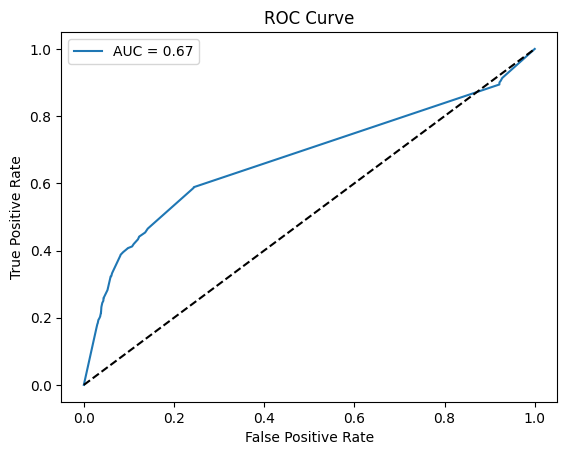

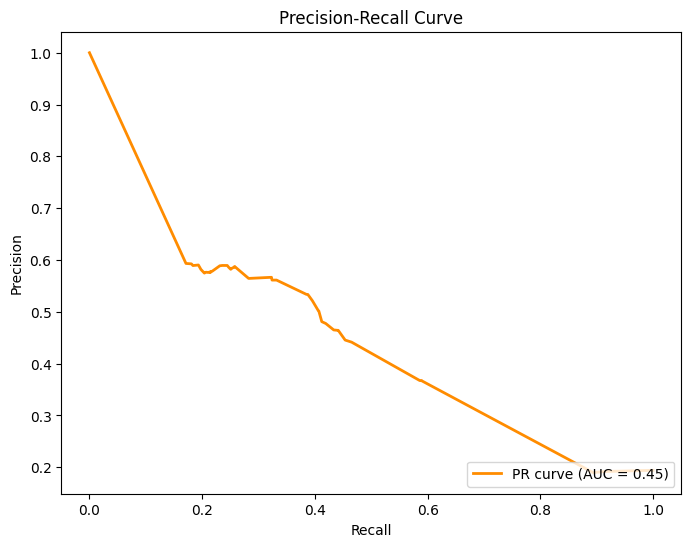

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the decision tree classifier and its hyperparameters
dt = DecisionTreeClassifier(random_state=42)
dt_params = {'max_depth': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 20, 50, 100]}

# Train and evaluate the decision tree classifier using 5-fold cross-validation
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_macro')
dt_grid.fit(train_features_final, train_label_transformed)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = dt_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Decision Tree Classifier with rating cutoff of 4')
print('Best Parameters:', dt_grid.best_params_)
print('Best F1 Score:', dt_grid.best_score_)

# Compute the validation metrics for the best model
best_dt = dt_grid.best_estimator_
valid_pred = best_dt.predict(valid_features_final)
print('Classification Report:', classification_report(valid_label_transformed, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_pred))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_pred))
print('AUC Score:', roc_auc_score(valid_label_transformed, best_dt.predict_proba(valid_features_final)[:,1]))
print('')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label_transformed, best_dt.predict_proba(valid_features_final)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label_transformed, best_dt.predict_proba(valid_features_final)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, best_dt.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use the best classifier to make predictions on the test data
test_pred = best_dt.predict(test_features_final)
test_df['binary_split_4'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['binary_split_4']})
submission_df.to_csv('Decision_Tree_4_withoutSK_submission.csv', index=False)


In [14]:
# Use the best classifier to make predictions on the test data
test_pred = best_dt.predict(test_features_final)
test_df['binary_split_4'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['binary_split_4']})
submission_df.to_csv('Decision_Tree_4_withoutSK_submission.csv', index=False)


Mean F1 Score: 0.7529164398958125 +/- 0.006696569067387986 for {'alpha': 0.001}
Mean F1 Score: 0.7463071004267011 +/- 0.0067183628930226206 for {'alpha': 0.05}
Mean F1 Score: 0.7442062456107204 +/- 0.0070571199570430235 for {'alpha': 0.1}
Mean F1 Score: 0.7292598292612075 +/- 0.006580353724903925 for {'alpha': 0.5}
Mean F1 Score: 0.7148586433204864 +/- 0.006696054015171705 for {'alpha': 1}
Mean F1 Score: 0.47386595539727283 +/- 0.0025279041317141124 for {'alpha': 10}
Multinomial Naive Bayes Classifier with rating cutoff of 4
Best Parameters: {'alpha': 0.001}
Best F1 Score: 0.7529164398958125
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.94      0.90      4705
           1       0.63      0.39      0.48      1133

    accuracy                           0.84      5838
   macro avg       0.75      0.67      0.69      5838
weighted avg       0.82      0.84      0.82      5838

Confusion Matrix:
 [[4443  262]
 [ 691  442]]
Accur

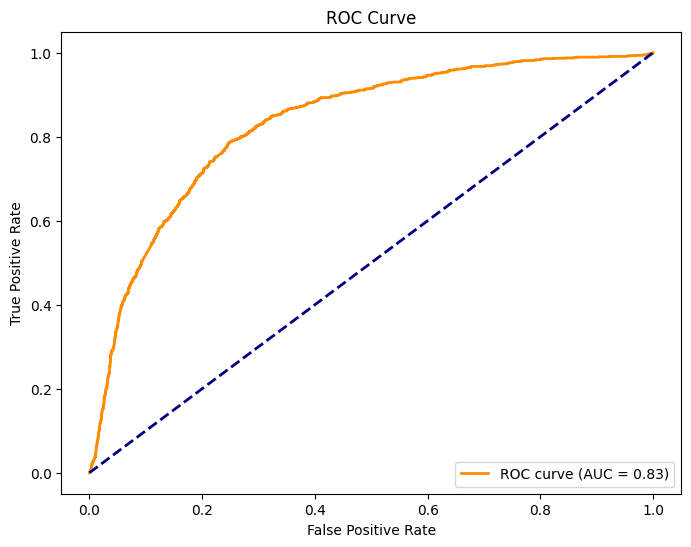

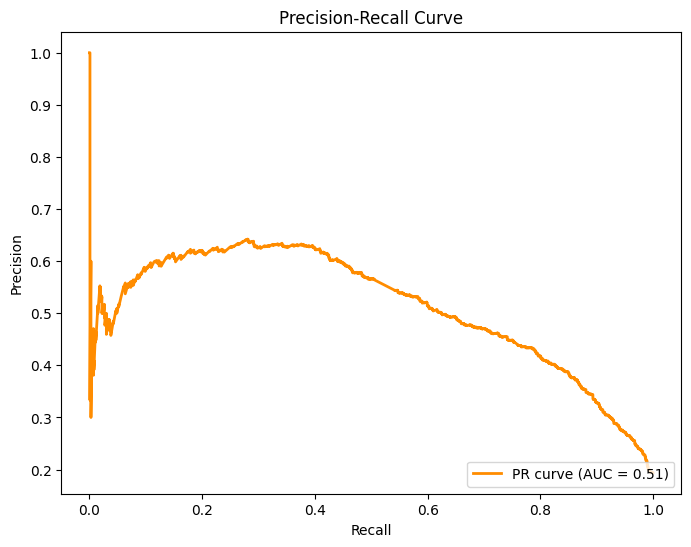

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the Multinomial Naive Bayes classifier and its hyperparameters
nb = MultinomialNB()
nb_params = {'alpha': [0.001, 0.05, 0.1, 0.5, 1, 10]}

# Train and evaluate the Multinomial Naive Bayes classifier using 5-fold cross-validation
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1_macro')
nb_grid.fit(train_features_final, train_label_transformed)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = nb_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Multinomial Naive Bayes Classifier with rating cutoff of 4')
print('Best Parameters:', nb_grid.best_params_)
print('Best F1 Score:', nb_grid.best_score_)

# Compute the validation metrics for the best model
best_nb = nb_grid.best_estimator_
valid_pred = best_nb.predict(valid_features_final)
print('Classification Report:', classification_report(valid_label_transformed, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_pred))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_pred))
print('AUC Score:', roc_auc_score(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1]))
print('')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label_transformed, best_nb.predict_proba(valid_features_final)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use the best classifier to make predictions on the test data
test_pred = best_nb.predict(test_features_final)
test_df['binary_split_4'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['binary_split_4']})
submission_df.to_csv('Multinomial_NB_4_withoutSK_submission.csv', index=False)


In [15]:
# Use the best classifier to make predictions on the test data
test_pred = best_nb.predict(test_features_final)
test_df['binary_split_4'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_4': test_df['binary_split_4']})
submission_df.to_csv('Multinomial_NB_4_withoutSK_submission.csv', index=False)
